In [27]:
import os
import shutil
import random
import torch
import warnings

import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score, roc_auc_score
from sklearn.exceptions import UndefinedMetricWarning

from torchvision import datasets, transforms
from torchvision.transforms import InterpolationMode
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import DatasetFolder
from torchvision.datasets.folder import default_loader
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.utils import save_image

from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

### Podela skupa podataka na train / validation / test

Ova funkcija služi za automatsku podelu skupa slika organizovanog po klasama u tri podskupa: **train**, **validation** i **test**.

**Opis funkcionalnosti:**
- Prolazi kroz sve klase (poddirektorijume) u izvornom direktorijumu
- U svakoj klasi bira maksimalno `max_per_class` slika
- Struktura klasa se zadržava u izlaznom direktorijumu
- Koristi se fiksni `seed` radi reproduktivnosti rezultata

In [1]:
def split_dataset(source_dir, output_dir, max_per_class=500,train_size=0.7, val_size=0.15, test_size=0.15, seed=42):
    random.seed(seed)
    
    assert abs(train_size + val_size + test_size - 1.0) < 1e-6, "Zbirovi moraju dati 1.0"
    
    class_names = os.listdir(source_dir)
    
    for class_name in class_names:
        class_dir = os.path.join(source_dir, class_name)
        images = os.listdir(class_dir)

        images = [img for img in images if img.lower().endswith((".jpg", ".png", ".jpeg"))]

        if len(images) > max_per_class:
            images = random.sample(images, max_per_class)
        else:
            print(f"Klasa {class_name} ima samo {len(images)} slika (traženo {max_per_class}).")

        train_imgs, temp_imgs = train_test_split(images, train_size=train_size, random_state=seed)
        val_imgs, test_imgs = train_test_split(temp_imgs, test_size=test_size / (test_size + val_size), random_state=seed)

        for split_name, split_imgs in zip(['train', 'val', 'test'], [train_imgs, val_imgs, test_imgs]):
            split_class_dir = os.path.join(output_dir, split_name, class_name)
            os.makedirs(split_class_dir, exist_ok=True)
            
            for img_name in split_imgs:
                src_path = os.path.join(class_dir, img_name)
                dst_path = os.path.join(split_class_dir, img_name)
                shutil.copy(src_path, dst_path)

Slike su preuzete sa [ https://www.kaggle.com/datasets/scolianni/mnistasjpg?utm_source=chatgpt.com ]. Koristi se samo `TrainingSamples` folder i uzima se 500 slika po cifri radi demonstracije.

In [31]:
split_dataset("TrainingSamples", "split_dataset")

# Definicije augmentacija

Ova klasa implementira **custom transformaciju** za dodavanje Gaussovog (normalnog) šuma na ulazne tenzore. Koristi kao deo **data augmentation** pipeline-a tokom treniranja.

In [33]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=0.05):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

### Transformacije

U ovoj ćeliji su definisane različite **image transformacije** korišćenjem `torchvision.transforms`.  
Sve slike se skaliraju na **224×224**, normalizuju pomoću ImageNet statistike (`mean`, `std`) i zatim prolaze kroz različite augmentacije poput rotacije, crop-a, translacije, šuma, zamućenja i promene boja.

In [34]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform_dict = dict()

transform_dict['ORIGINAL'] = transforms.Compose([
    transforms.Resize((224, 224), interpolation=InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

transform_dict['Crop'] = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.6, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

transform_dict['Rotate'] = transforms.Compose([
    transforms.Resize((224,224), interpolation=InterpolationMode.BICUBIC),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

transform_dict['Translate'] = transforms.Compose([
    transforms.Resize((224,224), interpolation=InterpolationMode.BICUBIC),
    transforms.RandomAffine(
        degrees=0,
        translate=(0.15, 0.15)
    ),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

transform_dict['Noise'] = transforms.Compose([
    transforms.Resize((224,224), interpolation=InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    AddGaussianNoise(0., 0.05),
    transforms.Normalize(mean, std),
])

transform_dict['Blur'] = transforms.Compose([
    transforms.Resize((224,224), interpolation=InterpolationMode.BICUBIC),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

transform_dict['RandomErase'] = transforms.Compose([
    transforms.Resize((224,224), interpolation=InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
    transforms.RandomErasing(
        p=0.5,
        scale=(0.02, 0.2),
        ratio=(0.3, 3.3),
        value='random'
    ),
])

transform_dict['ElasticDistorsion'] = transforms.Compose([
    transforms.Resize((224, 224), interpolation=InterpolationMode.BICUBIC),
    transforms.ElasticTransform(alpha=50.0, sigma=5.0),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

transform_dict['ColorSpace'] = transforms.Compose([
    transforms.Resize((224, 224), interpolation=InterpolationMode.BICUBIC),
    transforms.ColorJitter(
        brightness=0.3,   
        contrast=0.3,     
        saturation=0.3,  
        hue=0.05         
    ),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])


transform_dict['COMBINED'] = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),
    transforms.RandomApply([
        transforms.RandomRotation(3),
    ], p=0.3),
    transforms.RandomApply([
        transforms.ElasticTransform(alpha=40.0, sigma=5.0),
    ], p=0.3),
    transforms.RandomApply([
        transforms.ColorJitter(
            brightness=0.15,
            contrast=0.15,
            saturation=0.15,
            hue=0.03
        ),
    ], p=0.3),
    transforms.ToTensor(),
    AddGaussianNoise(0., 0.02),
    transforms.Normalize(mean, std),
    transforms.RandomErasing(p=0.25, scale=(0.02, 0.1)),
])

transform_dict['AugmentedGAN'] = transforms.Compose([
    transforms.Resize((224, 224), interpolation=InterpolationMode.BICUBIC),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

### Vizuelizacija efekata data augmentation transformacija

Ova ćelija učitava jedan primer slike cifre 5 iz trening skupa i primenjuje sve definisane transformacije iz `transform_dict` kako bi se **vizuelno uporedili njihovi efekti**.

Normalizacija se privremeno uklanja radi pravilnog prikaza slike.

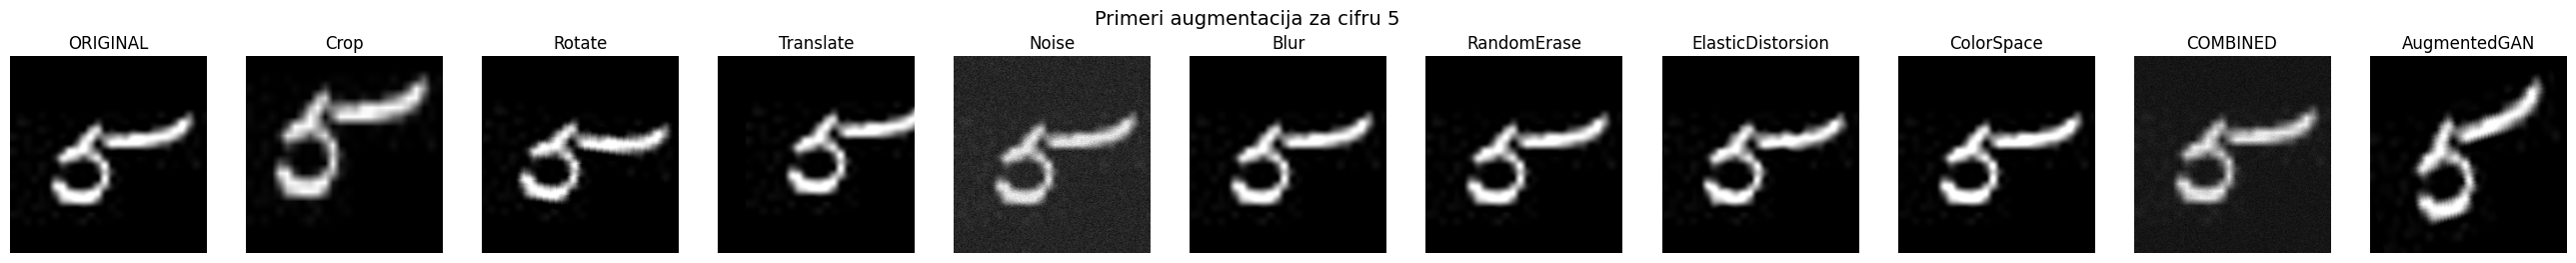

In [35]:
DIGIT = "5"   

digit_path = os.path.join("split_dataset/train", DIGIT)
img_name = os.listdir(digit_path)[0]
img_path = os.path.join(digit_path, img_name)

img = Image.open(img_path).convert("L")

n = len(transform_dict)
fig, axes = plt.subplots(1, n, figsize=(3*n, 3))

if n == 1:
    axes = [axes]

for ax, (name, transform) in zip(axes, transform_dict.items()):
    
    transform_no_norm = transforms.Compose([
        t for t in transform.transforms
        if not isinstance(t, transforms.Normalize)
    ])

    aug_img = transform_no_norm(img)

    if isinstance(aug_img, torch.Tensor):
        aug_img = aug_img.squeeze().numpy()

    ax.imshow(aug_img, cmap='gray')
    ax.set_title(name)
    ax.axis('off')

plt.suptitle(f"Primeri augmentacija za cifru {DIGIT}", fontsize=14)
plt.show()

In [36]:
transform_dict['GAN'] = transform_dict['ORIGINAL']

## Generisanje slika

### Custom Dataset za učitavanje slika iz jednog foldera

Ova klasa definiše PyTorch `Dataset` koji učitava **sve slike iz jednog direktorijuma**, bez labela. Namenjena je za rad sa već filtriranim slikama.

In [38]:
class SingleFolderImageDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.folder = folder
        self.transform = transform
        self.images = [
            os.path.join(folder, f)
            for f in os.listdir(folder)
            if f.lower().endswith((".png", ".jpg", ".jpeg"))
        ]

        if len(self.images) == 0:
            raise RuntimeError(f"Nema slika u folderu: {folder}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = Image.open(self.images[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img

### Definicija Generator i Discriminator mreža

U ovoj ćeliji su definisane neuronske mreže **Generator** i **Discriminator**.

- **Generator** prima latentni vektor šuma (`z`) i pomoću transponovanih konvolucija generiše RGB sliku.
- **Discriminator** prima sliku i procenjuje verovatnoću da je ona realna ili generisana.

In [39]:
class Generator(nn.Module):
    def __init__(self, z_dim=100):
        super().__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(z_dim, 256, 4, 1, 0),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 3, 4, 2, 1),
            nn.Sigmoid()
        )

    def forward(self, z):
        return self.net(z)

In [40]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 1, 4, 1, 0),
            nn.Sigmoid()
        )

    def forward(self, x):
        out = self.net(x)                 # [B, 1, H, W]
        out = out.view(out.size(0), -1)   # [B, H*W]
        return out.mean(dim=1)

### Treniranje GAN-a za jednu klasu

Ova funkcija trenira **GAN model (Generator + Discriminator)** nad slikama iz jednog foldera koji predstavlja jednu klasu (npr. jednu cifru).

- Slike se učitavaju pomoću `SingleFolderImageDataset`
- Po potrebi se primenjuje prosleđena augmentaciona transformacija
  
Funkcija vraća istrenirani **Generator**, koji se može koristiti za generisanje novih sintetičkih uzoraka date klase.

In [41]:
def train_gan_for_class(class_dir, epochs=20, batch_size=64, transform_Augm=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if transform_Augm:
        transform = transform_Augm
    else:
        transform = transforms.Compose([
            transforms.Resize((64, 64)),
            transforms.ToTensor()
        ])

    dataset = SingleFolderImageDataset(class_dir, transform=transform)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    G = Generator().to(device)
    D = Discriminator().to(device)

    opt_G = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
    opt_D = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

    criterion = nn.BCELoss()
    z_dim = 100

    for epoch in range(epochs):
        for real in loader:
            real = real.to(device)
            batch_size = real.size(0)
            real_labels = torch.ones(batch_size, device=device)
            fake_labels = torch.zeros(batch_size, device=device)

            noise = torch.randn(batch_size, z_dim, 1, 1).to(device)
            fake = G(noise)

            loss_D = (
                criterion(D(real), real_labels) +
                criterion(D(fake.detach()), fake_labels)
            )

            opt_D.zero_grad()
            loss_D.backward()
            opt_D.step()

            loss_G = criterion(D(fake), real_labels)

            opt_G.zero_grad()
            loss_G.backward()
            opt_G.step()

        print(
            f"[GAN][{os.path.basename(class_dir)}] "
            f"Epoch {epoch+1}/{epochs} | "
            f"D: {loss_D.item():.3f} | G: {loss_G.item():.3f}"
        )

    return G

Ova funkcija koristi istrenirani **Generator (GAN)** za kreiranje određenog broja novih, sintetičkih slika.

In [42]:
def generate_images(G, out_dir, n_images=300):
    os.makedirs(out_dir, exist_ok=True)
    device = next(G.parameters()).device

    for i in range(n_images):
        z = torch.randn(1, 100, 1, 1).to(device)
        fake = G(z)
        save_image(fake, f"{out_dir}/gan_{i}.png", normalize=False)

### Kopiranje sadržaja jednog foldera u drugi

Da bi se slike za GAN ne bi mešale sa slikama za druge modele.

In [43]:
def copy_folder(src_dir, dst_dir):
    if not os.path.exists(src_dir):
        raise FileNotFoundError(f"Izvorni folder '{src_dir}' ne postoji.")

    os.makedirs(dst_dir, exist_ok=True)

    for item in os.listdir(src_dir):
        src_path = os.path.join(src_dir, item)
        dst_path = os.path.join(dst_dir, item)

        if os.path.isdir(src_path):
            shutil.copytree(src_path, dst_path, dirs_exist_ok=True)
        else:
            shutil.copy2(src_path, dst_path)

    print(f"Sadržaj foldera '{src_dir}' je kopiran u '{dst_dir}'.")

### GAN

In [45]:
copy_folder("split_dataset/train", "split_dataset/train-gan")

train_root = "split_dataset/train-gan"

transform_GAN = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

for class_name in os.listdir(train_root):
    class_dir = os.path.join(train_root, class_name)

    if not os.path.isdir(class_dir):
        continue

    print(f"Treniram GAN za klasu: {class_name}")

    G = train_gan_for_class(class_dir, transform_Augm=transform_GAN)
    
    n_images = len(os.listdir(class_dir)) // 2
    generate_images(G, class_dir, n_images)

Sadržaj foldera 'split_dataset/train' je kopiran u 'split_dataset/train-gan'.
Treniram GAN za klasu: 0
[GAN][0] Epoch 1/20 | D: 0.167 | G: 4.195
[GAN][0] Epoch 2/20 | D: 0.062 | G: 4.830
[GAN][0] Epoch 3/20 | D: 0.038 | G: 5.415
[GAN][0] Epoch 4/20 | D: 0.022 | G: 5.652
[GAN][0] Epoch 5/20 | D: 0.015 | G: 5.953
[GAN][0] Epoch 6/20 | D: 0.012 | G: 6.164
[GAN][0] Epoch 7/20 | D: 0.011 | G: 6.207
[GAN][0] Epoch 8/20 | D: 0.009 | G: 6.321
[GAN][0] Epoch 9/20 | D: 0.007 | G: 6.591
[GAN][0] Epoch 10/20 | D: 0.006 | G: 6.724
[GAN][0] Epoch 11/20 | D: 0.006 | G: 6.901
[GAN][0] Epoch 12/20 | D: 0.004 | G: 7.001
[GAN][0] Epoch 13/20 | D: 0.004 | G: 6.947
[GAN][0] Epoch 14/20 | D: 0.004 | G: 6.967
[GAN][0] Epoch 15/20 | D: 0.004 | G: 6.972
[GAN][0] Epoch 16/20 | D: 0.004 | G: 7.060
[GAN][0] Epoch 17/20 | D: 0.003 | G: 7.283
[GAN][0] Epoch 18/20 | D: 0.003 | G: 7.304
[GAN][0] Epoch 19/20 | D: 0.003 | G: 7.362
[GAN][0] Epoch 20/20 | D: 0.002 | G: 7.438
Treniram GAN za klasu: 1
[GAN][1] Epoch 1/20 |

Prikaz slike broja 5 generisane generatorom.

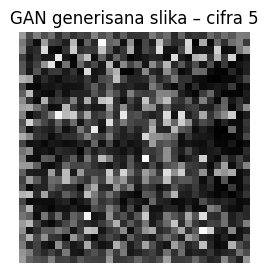

In [46]:
gan_dir = os.path.join(train_root, DIGIT)

gan_images = [
    f for f in os.listdir(gan_dir)
    if f.startswith("gan_") and f.lower().endswith(".png")
]

img_name = random.choice(gan_images)
img_path = os.path.join(gan_dir, img_name)

img = Image.open(img_path).convert("L")

plt.figure(figsize=(3, 3))
plt.imshow(img, cmap="gray")
plt.title("GAN generisana slika – cifra 5")
plt.axis("off")
plt.show()

### GAN + augmentacija

In [48]:
copy_folder("split_dataset/train", "split_dataset/train-aug-gan")

train_root = "split_dataset/train-aug-gan"

transform_AugmentedGAN = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.2
    ),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

for class_name in os.listdir(train_root):
    class_dir = os.path.join(train_root, class_name)

    if not os.path.isdir(class_dir):
        continue

    print(f"Treniram AugmentedGAN za klasu: {class_name}")

    G = train_gan_for_class(
        class_dir,
        transform_Augm=transform_AugmentedGAN
    )

    n_images = len(os.listdir(class_dir)) // 2
    generate_images(G, class_dir, n_images)

Sadržaj foldera 'split_dataset/train' je kopiran u 'split_dataset/train-aug-gan'.
Treniram AugmentedGAN za klasu: 0
[GAN][0] Epoch 1/20 | D: 0.218 | G: 4.162
[GAN][0] Epoch 2/20 | D: 0.076 | G: 4.961
[GAN][0] Epoch 3/20 | D: 0.040 | G: 5.515
[GAN][0] Epoch 4/20 | D: 0.025 | G: 5.831
[GAN][0] Epoch 5/20 | D: 0.019 | G: 6.064
[GAN][0] Epoch 6/20 | D: 0.014 | G: 6.294
[GAN][0] Epoch 7/20 | D: 0.012 | G: 6.397
[GAN][0] Epoch 8/20 | D: 0.010 | G: 6.496
[GAN][0] Epoch 9/20 | D: 0.009 | G: 6.602
[GAN][0] Epoch 10/20 | D: 0.008 | G: 6.714
[GAN][0] Epoch 11/20 | D: 0.006 | G: 6.921
[GAN][0] Epoch 12/20 | D: 0.006 | G: 6.812
[GAN][0] Epoch 13/20 | D: 0.005 | G: 6.963
[GAN][0] Epoch 14/20 | D: 0.004 | G: 7.001
[GAN][0] Epoch 15/20 | D: 0.004 | G: 7.097
[GAN][0] Epoch 16/20 | D: 0.004 | G: 7.185
[GAN][0] Epoch 17/20 | D: 0.003 | G: 7.146
[GAN][0] Epoch 18/20 | D: 0.003 | G: 7.294
[GAN][0] Epoch 19/20 | D: 0.003 | G: 7.341
[GAN][0] Epoch 20/20 | D: 0.003 | G: 7.380
Treniram AugmentedGAN za klasu: 1

Prikaz slike generisane uz korišćenje i augmentacija.

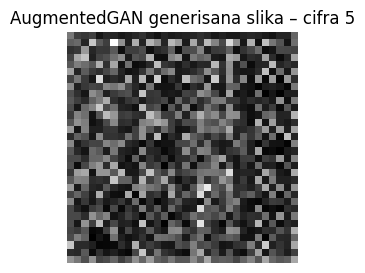

In [49]:
gan_dir = os.path.join(train_root, DIGIT)

gan_images = [
    f for f in os.listdir(gan_dir)
    if f.startswith("gan_") and f.lower().endswith(".png")
]

img_name = random.choice(gan_images)
img_path = os.path.join(gan_dir, img_name)

img = Image.open(img_path).convert("L")

plt.figure(figsize=(3, 3))
plt.imshow(img, cmap="gray")
plt.title("AugmentedGAN generisana slika – cifra 5")
plt.axis("off")
plt.show()

### Priprema podataka i hiperparametara za treniranje modela

In [50]:
results_dict = dict()
results_history = dict()

train_dir = "split_dataset/train"

val_dataset = datasets.ImageFolder("split_dataset/val", transform=transform_dict['ORIGINAL'])
test_dataset = datasets.ImageFolder("split_dataset/test", transform=transform_dict['ORIGINAL'])
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

batch_size = 32
num_classes = 10
num_epochs = 5
lr = 0.001

# Training Loop

### Evaluacija klasifikacionog modela

Funkcija ocenjuje performanse modela nad zadatim `dataloader`-om i vraća osnovne metrike.

In [52]:
def evaluate_model(model, dataloader, device):
    model.eval()

    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    metrics = {
        'Accuracy': accuracy_score(all_labels, all_preds),
        'Precision': precision_score(all_labels, all_preds, average='macro', zero_division=0),
        'Recall': recall_score(all_labels, all_preds, average='macro', zero_division=0),
        'F1': f1_score(all_labels, all_preds, average='macro', zero_division=0),
        'AUC-ROC macro': roc_auc_score(all_labels, all_probs, multi_class='ovr', average='macro'),
        'AUC-ROC micro': roc_auc_score(all_labels, all_probs, multi_class='ovr', average='micro')
    }

    return metrics

### Treniranje ResNet18 modela za klasifikaciju

Ova funkcija trenira **ResNet18** model na datom trening skupu i prati performanse na validation skupu.  

- Nakon završetka treniranja, model se evaluira na **test skupu** koristeći funkciju `evaluate_model` i vraća se model sa metriksama i istorijom treniranja

In [53]:
def train_model(train_dir, train_transform, val_loader, test_loader, batch_size=32, num_classes=10, num_epochs=10, lr=0.0001, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    weights = ResNet18_Weights.DEFAULT
    model = resnet18(weights=weights)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        correct_train, total_train = 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_loss = running_train_loss / len(train_loader)
        train_acc = correct_train / total_train

        model.eval()
        running_val_loss = 0.0
        correct_val, total_val = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()

                preds = torch.argmax(outputs, dim=1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

        val_loss = running_val_loss / len(val_loader)
        val_acc = correct_val / total_val

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

    metrics = evaluate_model(model, test_loader, device)

    return {
        'Model': model,
        **metrics
    }, history

Iterira se kroz sve transformacije definisane u `transform_dict` i trenira **ResNet18** model za svaku od njih.

In [54]:
for key, train_transform in transform_dict.items():
    print(f"Training with transform: {key}")

    if key == 'GAN':
        results_dict[key], results_history[key] = train_model("split_dataset/train-gan", train_transform, val_loader, test_loader)
    elif key == 'AugmentedGAN':
        results_dict[key], results_history[key] = train_model("split_dataset/train-aug-gan", train_transform, val_loader, test_loader)
    else:
        results_dict[key], results_history[key] = train_model(train_dir, train_transform, val_loader, test_loader, batch_size, num_classes, num_epochs, lr)

Training with transform: ORIGINAL
Epoch 1/5 | Train Loss: 0.2088, Train Acc: 0.9403 | Val Loss: 0.2261, Val Acc: 0.9280
Epoch 2/5 | Train Loss: 0.0953, Train Acc: 0.9709 | Val Loss: 0.0857, Val Acc: 0.9733
Epoch 3/5 | Train Loss: 0.0721, Train Acc: 0.9800 | Val Loss: 0.0700, Val Acc: 0.9773
Epoch 4/5 | Train Loss: 0.0435, Train Acc: 0.9863 | Val Loss: 0.2425, Val Acc: 0.9293
Epoch 5/5 | Train Loss: 0.0473, Train Acc: 0.9860 | Val Loss: 0.1097, Val Acc: 0.9680
Training with transform: Crop
Epoch 1/5 | Train Loss: 0.2851, Train Acc: 0.9151 | Val Loss: 0.2820, Val Acc: 0.9160
Epoch 2/5 | Train Loss: 0.0972, Train Acc: 0.9711 | Val Loss: 0.0683, Val Acc: 0.9760
Epoch 3/5 | Train Loss: 0.0986, Train Acc: 0.9720 | Val Loss: 0.1578, Val Acc: 0.9573
Epoch 4/5 | Train Loss: 0.0948, Train Acc: 0.9671 | Val Loss: 0.0545, Val Acc: 0.9787
Epoch 5/5 | Train Loss: 0.0617, Train Acc: 0.9789 | Val Loss: 0.1185, Val Acc: 0.9653
Training with transform: Rotate
Epoch 1/5 | Train Loss: 0.2340, Train Acc: 0

### Vizualizacija treniranja modela

Ova ćelija prikazuje **grafikone gubitka i tačnosti** tokom treniranja za svaku transformaciju iz `results_history`.

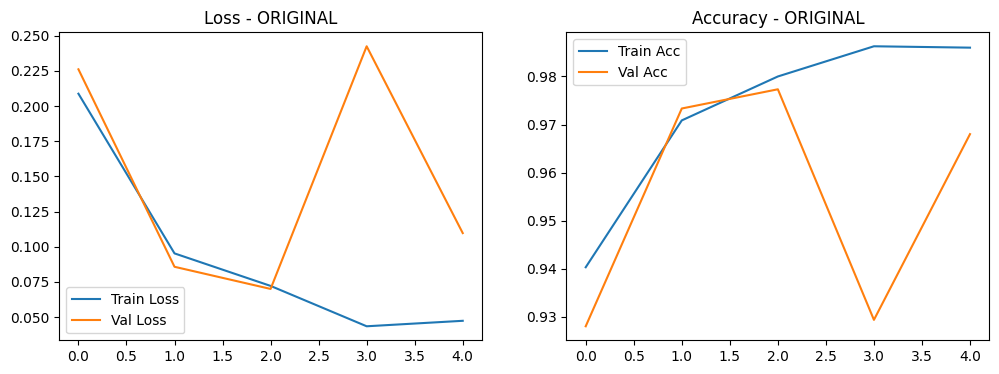

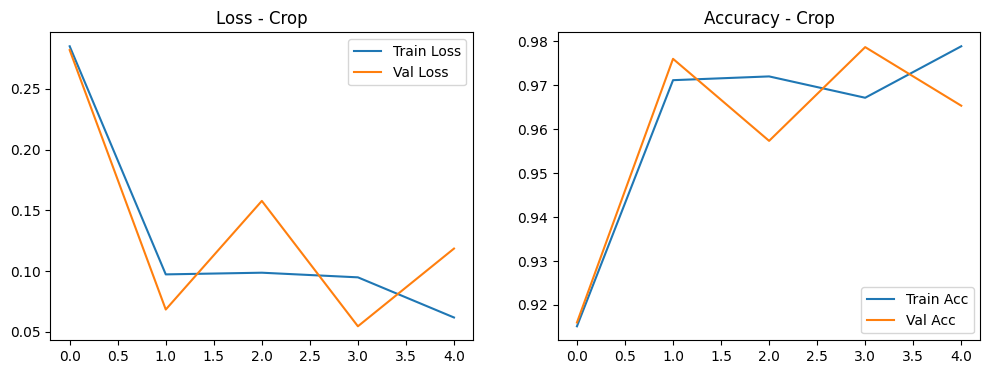

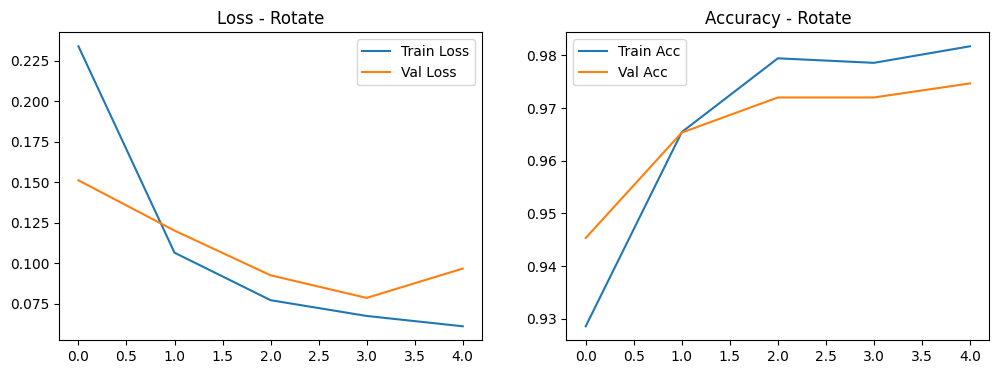

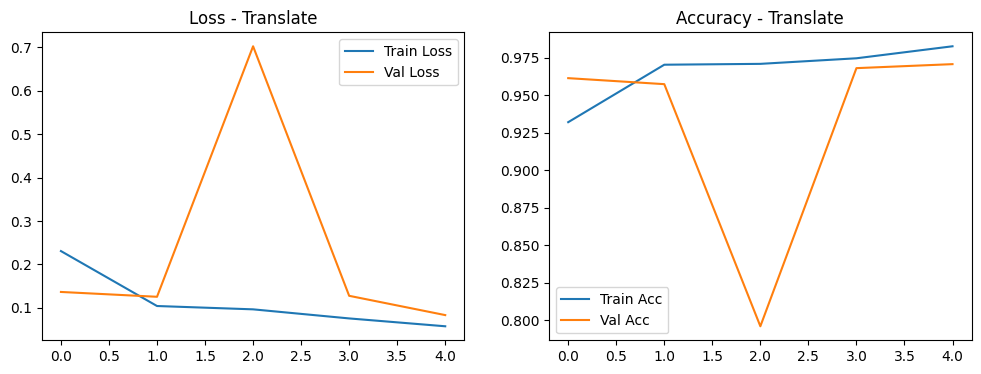

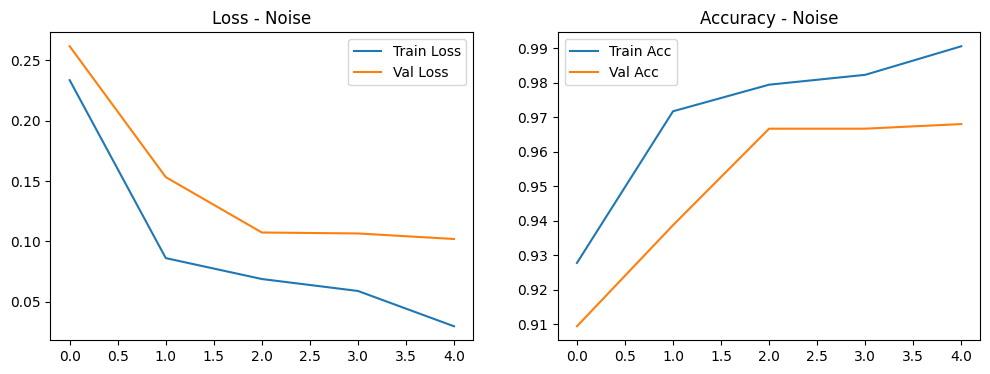

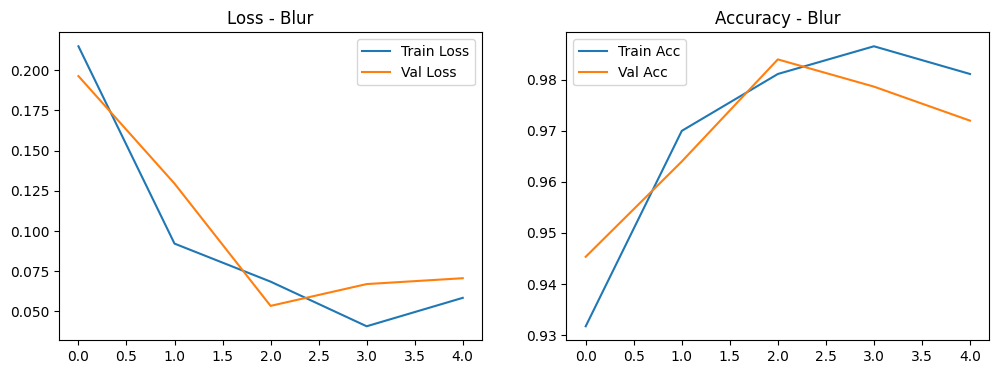

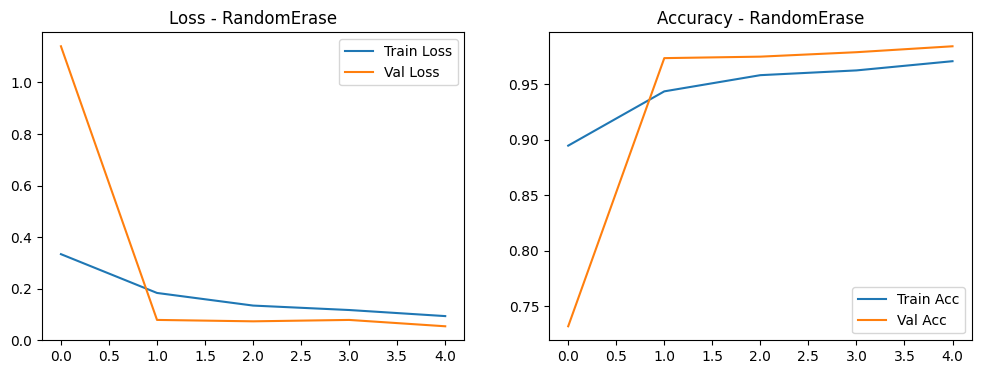

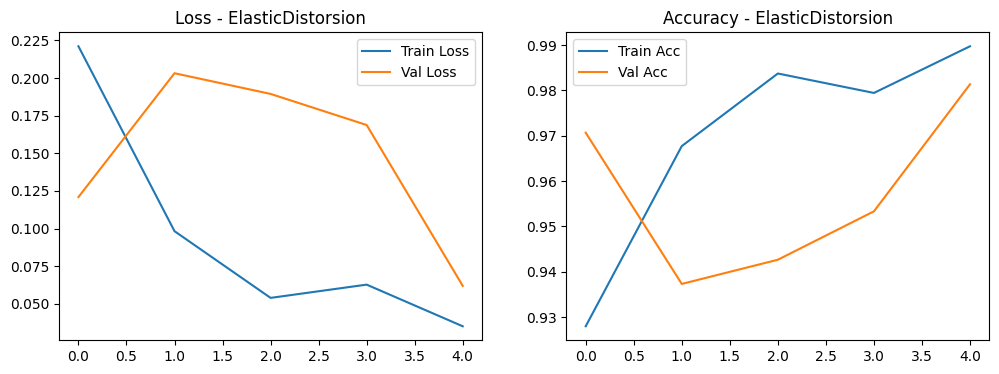

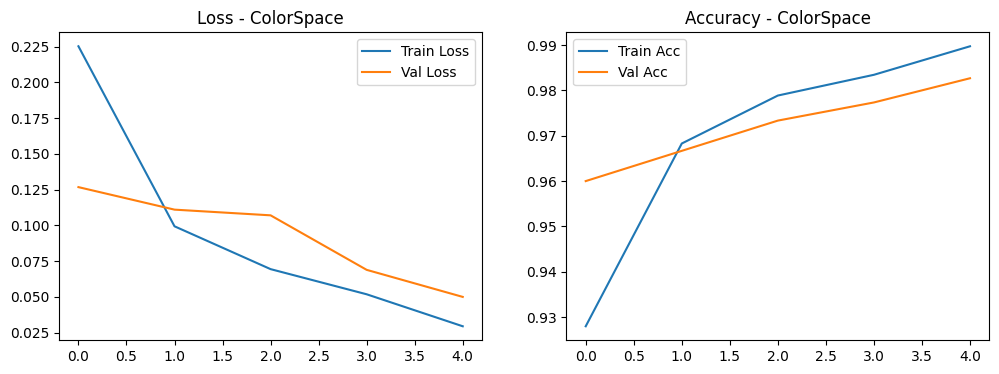

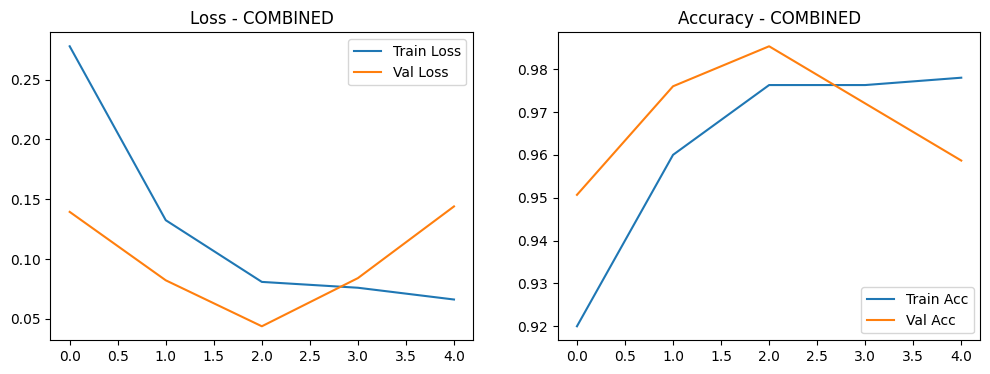

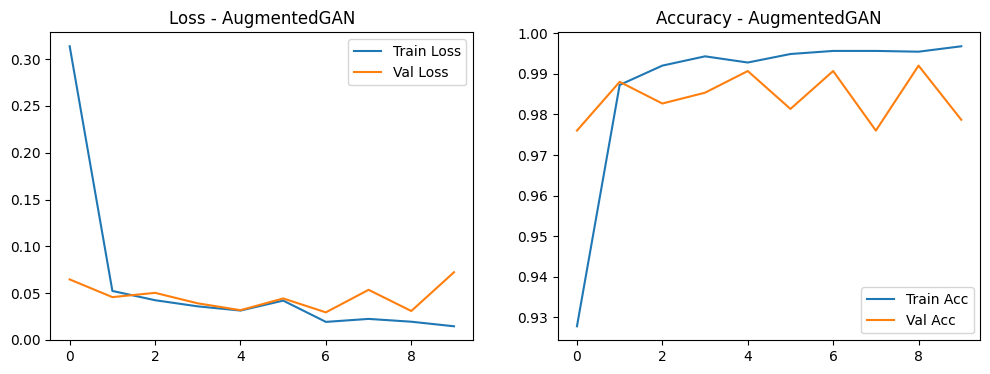

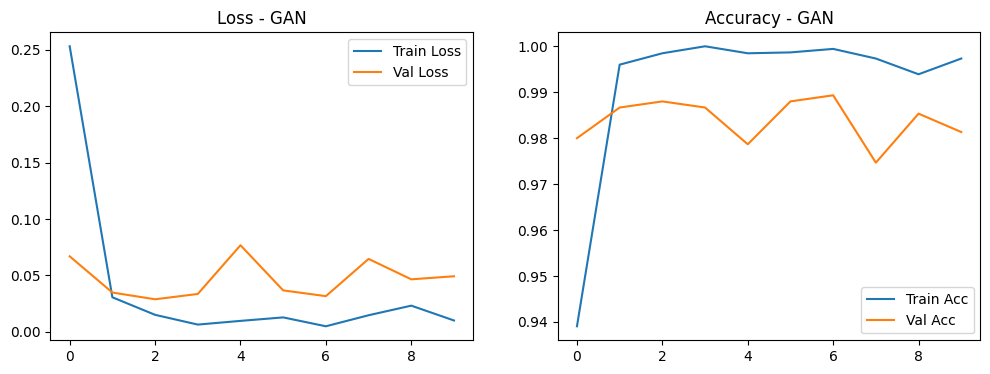

In [55]:
for name, history in results_history.items():
    plt.figure(figsize=(12,4))
    
    plt.subplot(1,2,1)
    plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Val Loss")
    plt.title(f"Loss - {name}")
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(history["train_acc"], label="Train Acc")
    plt.plot(history["val_acc"], label="Val Acc")
    plt.title(f"Accuracy - {name}")
    plt.legend()
    
    plt.show()

In [56]:
df = pd.DataFrame(results_dict).T
df = df.drop(columns=["Model"])
df = df.apply(pd.to_numeric)

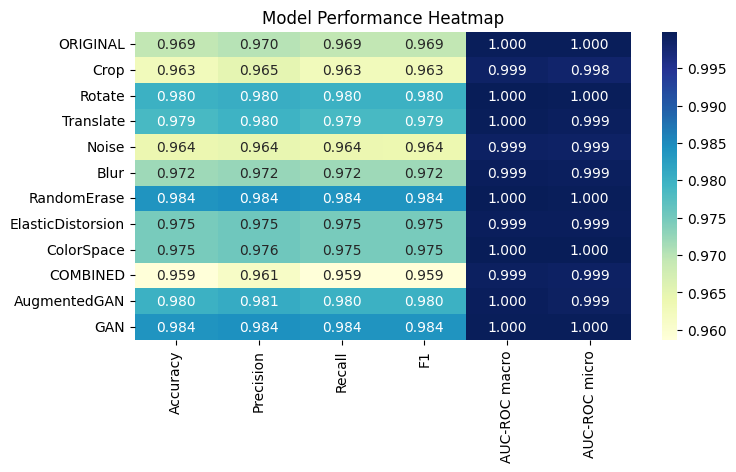

In [57]:
plt.figure(figsize=(8, 4))
sns.heatmap(
    df,
    annot=True,           
    cmap="YlGnBu", 
    fmt='.3f'
)

plt.title("Model Performance Heatmap")
plt.show()

## External Test Set [ https://www.kaggle.com/datasets/ayavariabdi/didadataset?select=10000 ]

Provera kako bi se modeli pokazali na drugačijim slikama. To pokazuje primenljivost u realnim situacijama. Cilj je videti da li se modeli koji koriste augmentaciju bolje snalaze.

In [59]:
src_dir = "10000/10000"
dst_dir = "check_validation"

os.makedirs(dst_dir, exist_ok=True)

for class_name in os.listdir(src_dir):
    class_src_path = os.path.join(src_dir, class_name)
    class_dst_path = os.path.join(dst_dir, class_name)
    
    os.makedirs(class_dst_path, exist_ok=True)
    
    all_images = [f for f in os.listdir(class_src_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    sample_images = random.sample(all_images, min(500, len(all_images)))
    
    for img_name in sample_images:
        src_path = os.path.join(class_src_path, img_name)
        dst_path = os.path.join(class_dst_path, img_name)
        shutil.copy(src_path, dst_path)

print("Sampling završen!")

Sampling završen!


In [60]:
check_val_dataset = datasets.ImageFolder("check_validation", transform=transform_dict['ORIGINAL'])
check_val_loader = DataLoader(check_val_dataset, batch_size=32)

In [61]:
models_dict = {k: results_dict[k]['Model'] for k in results_dict.keys()}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

results = {}

for model_name, model in models_dict.items():
    model = model.to(device)

    metrics = evaluate_model(model, check_val_loader, device)

    results[model_name] = {
        'Model': model,
        **metrics
    }

In [62]:
df_results = pd.DataFrame(results).T
df_results = df_results.drop(columns=["Model"])
df_results = df_results.apply(pd.to_numeric)

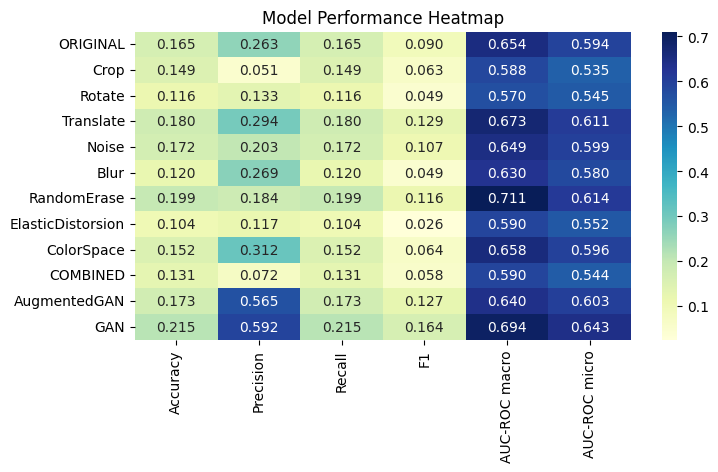

In [63]:
plt.figure(figsize=(8, 4))
sns.heatmap(
    df_results,
    annot=True, 
    cmap="YlGnBu",
    fmt='.3f'
)

plt.title("Model Performance Heatmap")
plt.show()